In [1]:
#This program fits the O-PPAC data onto a FCNN model
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, metrics, Model
from tensorflow.keras.callbacks import Callback
from sklearn.model_selection import train_test_split
import tensorflow_docs.plots
import tensorflow_docs.modeling
import numpy as np
from numpy import *
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import h5py
import datetime
import FWHM #my module
from FWHM import *

In [2]:
dataset = np.load("OPPAC_Data/recomplied_dataset_fixed.npy")
all_data = dataset[ : , :132]
all_labels = dataset[: , -2:]

print(all_data.shape)
print(all_labels.shape)

(338636, 132)
(338636, 2)


In [3]:
train_data, test_data, train_labels, test_labels = train_test_split(all_data, all_labels, test_size=0.2,shuffle=True)
#splits training and test data for the FCNN; 20% set aside for testing

In [4]:
print(train_data.ndim)
print(train_data.shape)
print(train_data[0])

2
(270908, 132)
[0.         0.00684622 0.00342311 0.00342311 0.00342311 0.04107735
 0.15746316 0.11980893 0.18827117 0.13350138 0.06161602 0.0273849
 0.         0.         0.01026934 0.         0.         0.
 0.         0.00342311 0.         0.         0.         0.00342311
 0.         0.         0.         0.         0.00342311 0.
 0.         0.         0.         0.         0.00342311 0.
 0.         0.         0.00342311 0.00342311 0.23619474 0.52373617
 0.17457872 0.00342311 0.         0.         0.         0.00342311
 0.         0.         0.         0.         0.00342311 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.00342311 0.         0.         0.00342311 0.04450046 0.13007826
 0.18484806 0.1951174  0.17800184 0.10611648 0.02396179 0.00684622
 0.         0.         0.00342311 0.         0.         0.
 0.00684622 0.         0.         0.         0.         0.
 0.         0.         0.         0.        

In [5]:
#early stopping mechanism; can increase amount of time before stopping by increasing patience
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5,min_delta=0.0001,min_lr=0.0001)

In [6]:
#Fully connected neural network
#the "layers" are the dense hidden layers which are fully connected
#first number changes the nodes, 2nd is the activation function, (first line has number of inputs as well)

FCNN_model = tf.keras.Sequential()
FCNN_model.add(layers.Dense(256, activation='relu', input_shape = [132]))
FCNN_model.add(layers.Dense(256, activation = 'relu'))
FCNN_model.add(layers.Dense(256, activation = 'relu'))
#FCNN_model.add(layers.Dense(128, activation = 'relu'))
#FCNN_model.add(layers.Dropout(0.2))
FCNN_model.add(layers.Dense(2, activation = 'linear'))

In [7]:
#compiles the FCNN and includes the learning rate as well
FCNN_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005), 
              loss = 'mse', 
              metrics=['mae', 'mse'])

In [8]:
FCNN_history = FCNN_model.fit(train_data, train_labels,
                    epochs = 100,
                    batch_size = 32,
                    callbacks = [reduce_lr],
                    validation_split = 0.3 
                    )

Epoch 1/100
5927/5927 [==============================] - 15s 2ms/step - loss: 26.5857 - mae: 1.7378 - mse: 26.5857 - val_loss: 0.2607 - val_mae: 0.4020 - val_mse: 0.2607
Epoch 2/100
5927/5927 [==============================] - 14s 2ms/step - loss: 0.2150 - mae: 0.3463 - mse: 0.2150 - val_loss: 0.1913 - val_mae: 0.3497 - val_mse: 0.1913
Epoch 3/100
5927/5927 [==============================] - 14s 2ms/step - loss: 0.1204 - mae: 0.2641 - mse: 0.1204 - val_loss: 0.0911 - val_mae: 0.2421 - val_mse: 0.0911
Epoch 4/100
5927/5927 [==============================] - 15s 2ms/step - loss: 0.0868 - mae: 0.2272 - mse: 0.0868 - val_loss: 0.0743 - val_mae: 0.2118 - val_mse: 0.0743
Epoch 5/100
5927/5927 [==============================] - 14s 2ms/step - loss: 0.0746 - mae: 0.2104 - mse: 0.0746 - val_loss: 0.0940 - val_mae: 0.2425 - val_mse: 0.0940
Epoch 6/100
5927/5927 [==============================] - 14s 2ms/step - loss: 0.0599 - mae: 0.1904 - mse: 0.0599 - val_loss: 0.0543 - val_mae: 0.1833 - val_ms

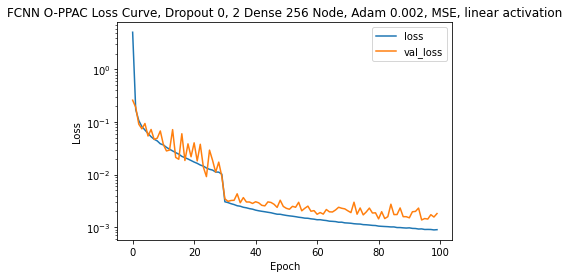

In [9]:
#loss plot of training and test data
plt.plot(FCNN_history.history['loss'], label='loss')
plt.plot(FCNN_history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.yscale('log')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title("FCNN O-PPAC Loss Curve, Dropout 0, 2 Dense 256 Node, Adam 0.002, MSE, linear activation")
plt.show()

In [19]:
# serialize model to JSON
FCNNmodel = FCNN_model.to_json()
with open("FCNNmodel", "w") as json_file:
    json_file.write(FCNNmodel)
# serialize weights to HDF5
FCNN_model.save_weights("FCNNmodel_weights_Khalil.h5")

In [20]:
#to reload model from before:

    # load json and create model
#model_file = open('FCNN', 'r')
#loaded_FCNN_model = model_file.read()
#model_file.close()
#FCNN_model = model_from_json(loaded_FCNN_model)

    # load weights into new model
#FCNN_model.load_weights("FCNNmodel_weights_Khalil.h5")

In [21]:
#separation of 'result' values (stats from test data)
result = FCNN_model.evaluate(test_data, test_labels, verbose=2)

2117/2117 - 2s - loss: 8.9114e-04 - mae: 0.0204 - mse: 8.9114e-04


In [22]:
#separation of 'prediction' values (training data)
predictions = FCNN_model.predict(test_data)

In [23]:
#separates x and y predicted values so there can be separate graphs for each
x_pred = predictions[:,0]
y_pred = predictions[:,1]

#separates x and y labels for comparisons to the predicted locations
x_test = np.array(test_labels[:,0])
y_test = np.array(test_labels[:,1])

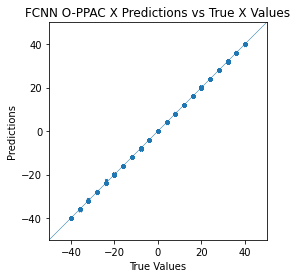

In [24]:
#graph showing the accuracy of model by comparing predicted and true x values
#should be as close to the diagonal as possible
a = plt.axes(aspect='equal')
plt.scatter(x_test, x_pred, s=6, marker = "x")
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [-50, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims, linewidth = .5)
plt.title("FCNN O-PPAC X Predictions vs True X Values")
plt.show()

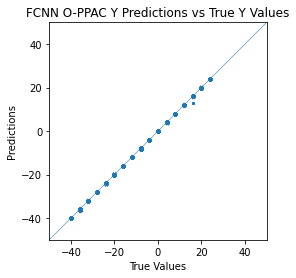

In [25]:
#graph showing the accuracy of model by comparing predicted and true y values
#should be as close to the diagonal as possible
a = plt.axes(aspect='equal')
plt.scatter(y_test, y_pred, s=6, marker = "x")
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [-50, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims, linewidth = .5)
plt.title("FCNN O-PPAC Y Predictions vs True Y Values")
plt.show()

In [26]:
#to find the locations of largest error within my predicted x values
x_error = x_pred - x_test

#this takes all the points with error greater than 1 mm
xerror_list = [err for (idx, err) in enumerate(x_error) if err >= 1]
print(xerror_list)

[1.4721336364746094]


In [27]:
#to find the locations of largest error within my predicted y values (same as the x code above but specific to y)
y_error = y_pred - y_test 

yerror_list = [ err for (idx, err) in enumerate(y_error) if err >= 1]
print(yerror_list)

[]


In [28]:
# setting up for residue plot of x-error from the model
error_list_x = [i for i in x_error if abs(i) <= .5]
print(len(error_list_x))

67724


In [29]:
# setting up for residue plot of y-error from the model
error_list_y = [i for i in y_error if abs(i) <= .5]
print(len(error_list_y))

67727


In [30]:
def gaussianpdf(x, k, sigma, mu):
    return k*np.exp(-0.5*((x-mu)/sigma)**2)

def full_half(data):
    bin_heights, bin_borders, _ = plt.hist(data, bins='auto', label='Residual')
    bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
    popt, _ = curve_fit(gaussianpdf, bin_centers, bin_heights, p0=[60., 10., 30.])
    fwhm = popt[1]*2.355
    
    x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000) #the x interval the fit is put over
    plt.plot(x_interval_for_fit, gaussianpdf(x_interval_for_fit, *popt), label='Gaussian Fit')
    gauss = gaussianpdf(x_interval_for_fit, *popt) #y data for the gaussian fit if needed to be plotted separately
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    return np.abs(fwhm)

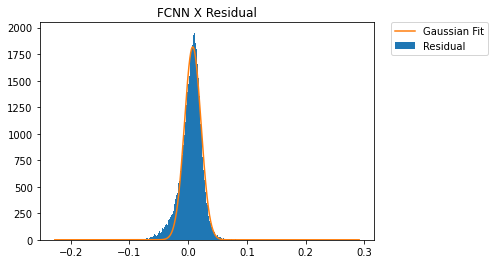

0.033106904538943153


In [31]:
x_fwhm = full_half(error_list_x)
plt.title('FCNN X Residual')
plt.show()
print(x_fwhm)

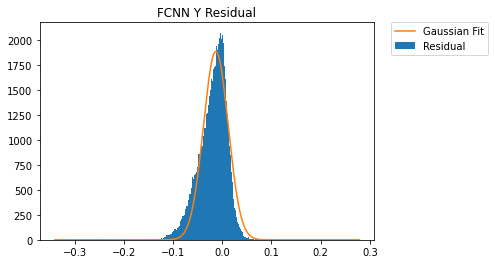

0.05921131790925778


In [32]:
y_fwhm = full_half(error_list_y)
plt.title('FCNN Y Residual')
plt.show()
print(y_fwhm)